C:\Users\Chrono460\AppData\Local\Temp\ipykernel_9072\872040720.py:43: RuntimeWarning: divide by zero encountered in divide
  INVK2 = np.where(K2==0, 0, 1.0/K2)


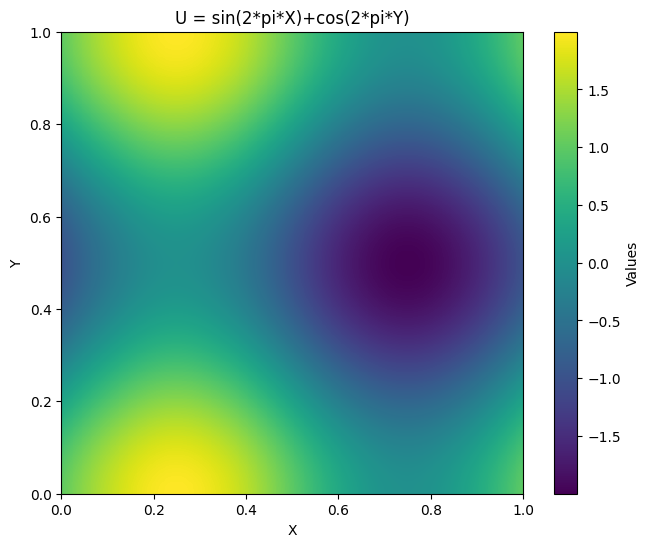

In [136]:
# %%
import numpy as np
from numpy.fft import rfft2, irfft2, rfftfreq, fftfreq
import matplotlib.pyplot as plt
import vtk

np.random.seed(42)

# Define the grid dimensions
nx = 1024  # Number of points in x direction
ny = 1024  # Number of points in y direction

# Define the range for x and y
x_min, x_max = 0, 1  # Range for x
y_min, y_max = 0, 1  # Range for y

# Create the vertices
x_vertices = np.linspace(x_min, x_max, nx+1)  # Create x values
y_vertices = np.linspace(y_min, y_max, ny+1)  # Create y values

# Use meshgrid to create the 2D vertices grid
XV, YV = np.meshgrid(x_vertices, y_vertices)

# Create the cell centers
x_centers = (x_vertices[:-1]+x_vertices[1:]) / 2.0  # Create x values
y_centers = (y_vertices[:-1]+y_vertices[1:]) / 2.0  # Create y values

# Use meshgrid to create the 2D grid
X, Y = np.meshgrid(x_centers, y_centers)

# Calculate the step sizes in x and y directions
dx = x_centers[1] - x_centers[0]
dy = y_centers[1] - y_centers[0]

# Calculate the wavenumbers in x and y directions
kx = 2 * np.pi * rfftfreq(nx, dx)
ky = 2 * np.pi * fftfreq(ny, dy)

# Use meshgrid to create the 2D grid
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2
K = np.sqrt(K2)
INVK2 = np.where(K2==0, 0, 1.0/K2)
SPEC_FILTER = np.where(K > 2.0 / 3.0 * np.max(K), 0, 1 )

# Test gradients
U = np.sin(2*np.pi*X)+np.cos(2*np.pi*Y)
DUDX = 2*np.pi*np.cos(2*np.pi*X)
DUDY = -2*np.pi*np.sin(2*np.pi*Y)

UHAT = rfft2(U)
DUDX_FFT = irfft2(1j*KX*UHAT)
DUDY_FFT = irfft2(1j*KY*UHAT)

# Plot the U
plt.figure(figsize=(8, 6))
plt.pcolor(XV, YV, U, cmap='viridis')  # Change X + Y to any function you want to plot
plt.colorbar(label='Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('U = sin(2*pi*X)+cos(2*pi*Y)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Plot the DUDX
plt.figure(figsize=(8, 6))
plt.pcolor(XV, YV, DUDX-DUDX_FFT, cmap='viridis')  # Change X + Y to any function you want to plot
plt.colorbar(label='Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DUDX')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Plot the DUDY
plt.figure(figsize=(8, 6))
plt.pcolor(XV, YV, DUDY-DUDY_FFT, cmap='viridis')  # Change X + Y to any function you want to plot
plt.colorbar(label='Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DUDY')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [137]:
def add_arrays_to_ndarray(ndarray, *arrays):
    ndims = len(ndarray.shape)
    for i, arr in enumerate(arrays):
        for _ in range(i):
            arr = np.expand_dims(arr, axis=0)
        for _ in range(ndims-i-1):
            arr = np.expand_dims(arr, axis=-1)
        ndarray = ndarray + arr
    return ndarray
    
def noise_psd(N, psd = lambda f: 1):
    ndims = len(N)
    X_white = np.fft.rfftn(np.random.randn(*N))
    fsqr_arrays = tuple(np.fft.fftfreq(N[idim])**2 for idim in range(ndims-1)) + (np.fft.rfftfreq(N[-1])**2,)
    f_radii = np.zeros(X_white.shape)
    f_radii = np.sqrt(add_arrays_to_ndarray(f_radii, *fsqr_arrays))
    S = psd(f_radii)
    # Normalize S
    S = S / np.sqrt(np.mean(S**2))
    X_shaped = X_white * S
    return np.fft.irfftn(X_shaped)

def PSDGenerator(f):
    return lambda *N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f)

@PSDGenerator
def violet_noise(f):
    return f

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

In [138]:
def create_vtk_image_data(omega):
    # Create vtkImageData
    imageData = vtk.vtkImageData()
    imageData.SetDimensions(nx, ny, 1)
    imageData.SetSpacing(dx, dy, 1)
    imageData.SetOrigin(x_min, y_min, 0)
    
    # Create temperature data array
    tempArray = vtk.vtkDoubleArray()
    tempArray.SetName("omega")
    tempArray.SetNumberOfComponents(1)
    tempArray.SetNumberOfTuples(nx * ny)
    tempArray.SetArray(omega.ravel(), nx * ny, 1)
    imageData.GetPointData().SetScalars(tempArray)
    
    return imageData

def write_vtk_image_data(imageData, filename):
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(filename)
    writer.SetInputData(imageData)
    writer.Write()

(512, 512)


Text(0.5, 1.0, 'V')

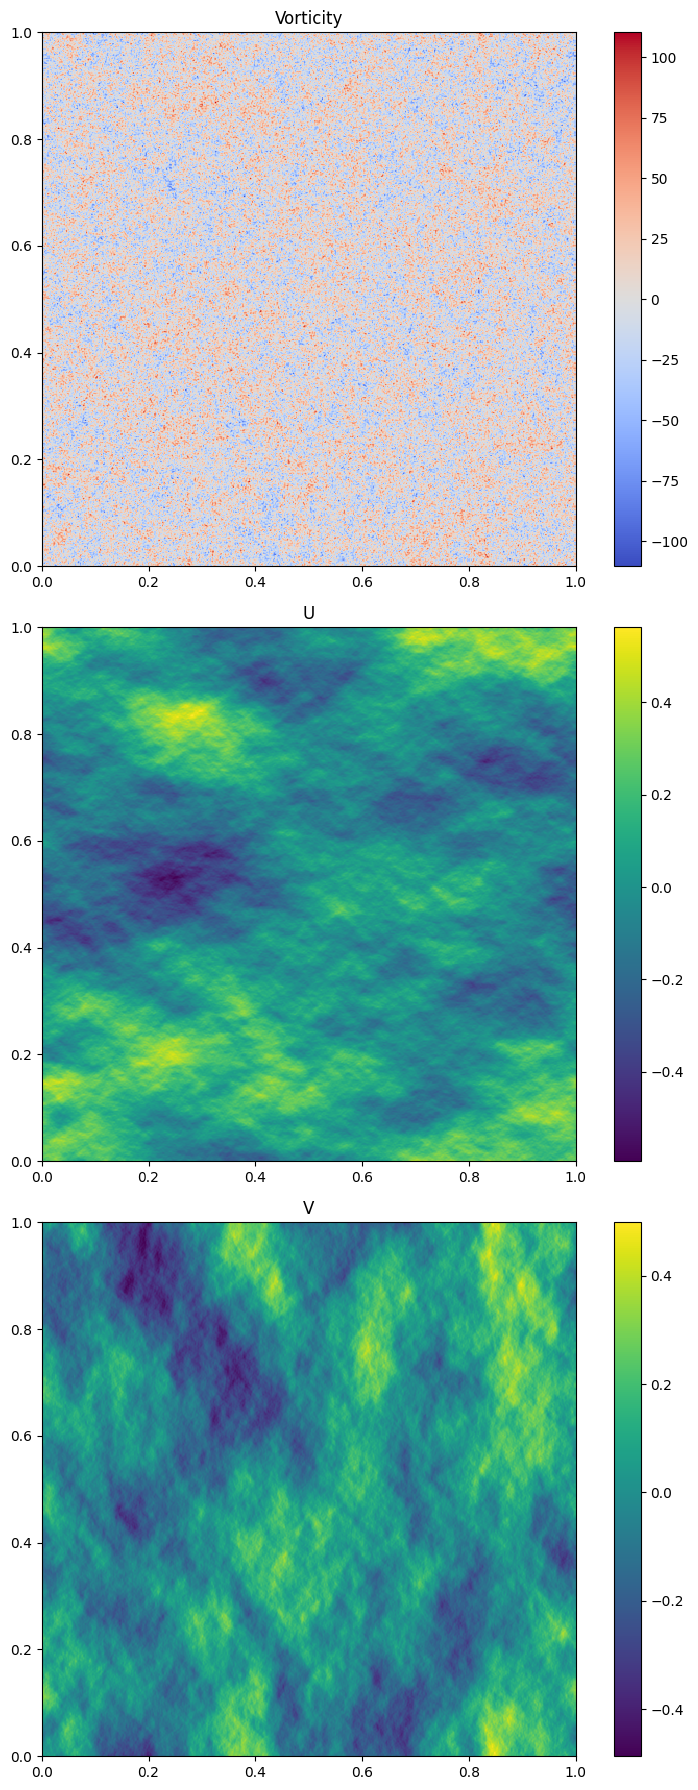

In [139]:
OMEGA = irfft2(rfft2(pink_noise(ny, nx))*SPEC_FILTER)*(ny/100*nx/100)
PSIHAT = rfft2(OMEGA) * INVK2
U = irfft2(1j*KY*PSIHAT)
V =-irfft2(1j*KX*PSIHAT)
print(OMEGA.shape)

imageData = create_vtk_image_data(OMEGA)
filename = f"results/structured_grid_time_0.vti"
write_vtk_image_data(imageData, filename)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 18), tight_layout=True)
img1 = ax1.pcolor(XV, YV, OMEGA, vmax=np.max(np.abs(OMEGA)), vmin=-np.max(np.abs(OMEGA)), cmap='coolwarm')
plt.colorbar(img1, ax=ax1)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title("Vorticity")
img2 = ax2.pcolor(XV, YV, U, cmap='viridis')
plt.colorbar(img2, ax=ax2)
ax2.set_aspect('equal', adjustable='box')
ax2.set_title("U")
img3 = ax3.pcolor(XV, YV, V, cmap='viridis')
plt.colorbar(img3, ax=ax3)
ax3.set_aspect('equal', adjustable='box')
ax3.set_title("V")


In [140]:
# Streamlines plot
speed = np.sqrt(U*U + V*V)
lw = 2.5*speed / speed.max()
fig0, ax0 = plt.subplots(figsize=(12, 8), tight_layout=True)
strm = ax0.streamplot(X, Y, U, V, density=4, color='k', linewidth=lw, cmap="turbo")
fig0.colorbar(strm.lines)

plt.show()

In [141]:
OMEGAH = rfft2(pink_noise(ny, nx))*SPEC_FILTER*(ny/100*nx/100)
PSIHAT = OMEGAH * INVK2
U = irfft2(1j*KY*PSIHAT)
V =-irfft2(1j*KX*PSIHAT)
E0 = 0.5*np.sum(U**2+V**2)

nu = 1e-6
nt = 501
nt_sub = 20
t = 0
CFL = 0.5
dt = CFL/max(np.max(np.abs(U/dx)),np.max(np.abs(V/dy)))
print(dt)


def N(OMEGAH):
    PSIHAT = OMEGAH * INVK2
    NONL = irfft2(1j*KY*PSIHAT)*irfft2(1j*KX*OMEGAH) - irfft2(1j*KX*PSIHAT)*irfft2(1j*KY*OMEGAH)
    NONL = rfft2(NONL) * SPEC_FILTER
    NONL += -nu * K2 * OMEGAH
    return NONL

for i in range(nt):
    for _ in range(nt_sub):
        k1 = dt * N(OMEGAH)
        k2 = dt * N(OMEGAH+1.0/2.0*k1)
        k3 = dt * N(OMEGAH+1.0/2.0*k2)
        k4 = dt * N(OMEGAH+k3)
        OMEGAH += 1.0/6.0*(k1 + 2*k2 + 2*k3 + k4)
        t += dt

    PSIHAT = OMEGAH * INVK2
    U = irfft2(1j*KY*PSIHAT)
    V =-irfft2(1j*KX*PSIHAT)
    OMEGA = irfft2(OMEGAH)
    E = 0.5*np.sum(U**2+V**2)
    CFL = dt*max(np.max(np.abs(U/dx)),np.max(np.abs(V/dy)))
    print(i, t, CFL, E/E0)

    imageData = create_vtk_image_data(OMEGA)
    filename = f"results/structured_grid_time_{i:03d}.vti"
    write_vtk_image_data(imageData, filename)


'''
# Write the .pvd file manually
pvd_content = '<?xml version="1.0"?>\n'
pvd_content += '<VTKFile type="Collection" version="0.1" byte_order="LittleEndian">\n'
pvd_content += '  <Collection>\n'
for t, file in enumerate(filenames):
    pvd_content += f'    <DataSet timestep="{t}" group="" part="0" file="{file}"/>\n'
pvd_content += '  </Collection>\n'
pvd_content += '</VTKFile>\n'

with open("time_series.pvd", "w") as f:
    f.write(pvd_content)
'''


0.0013939636020049015
0 0.013939636020049016 0.48804627450696764 0.9997741960831236
1 0.02787927204009804 0.48780549934933853 0.9995534189727985
2 0.04181890806014706 0.4817342766069812 0.9993380298147745
3 0.055758544080196086 0.4750827914832036 0.9991265830884661
4 0.0696981801002451 0.47702840140467156 0.9989201495118674
5 0.08363781612029413 0.4813960214612275 0.9987184484857207
6 0.09757745214034315 0.47963850406833597 0.9985203556725514
7 0.11151708816039217 0.4770837907436284 0.9983269273755717
8 0.12545672418044118 0.4743501279750083 0.9981371066759365
9 0.13939636020049007 0.47587976755291167 0.9979513938321264
10 0.15333599622053895 0.4754674740631621 0.9977688488036368
11 0.16727563224058783 0.4744255783340808 0.997590102487644
12 0.18121526826063672 0.46683069624087853 0.9974148315720532
13 0.1951549042806856 0.46202454271242327 0.9972433784137197
14 0.2090945403007345 0.4640578766815792 0.9970751552773198
15 0.22303417632078337 0.4669334401344699 0.9969104352040321
16 0.23

KeyboardInterrupt: 

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
img1 = ax1.pcolor(XV, YV, OMEGA, vmax=np.max(np.abs(OMEGA)), vmin=-np.max(np.abs(OMEGA)), cmap='coolwarm')
plt.colorbar(img1, ax=ax1)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title("Vorticity")

# Streamlines plot
speed = np.sqrt(U*U + V*V)
lw = 2.5*speed / speed.max()
fig0, ax0 = plt.subplots(figsize=(12, 8), tight_layout=True)
strm = ax0.streamplot(X, Y, U, V, density=2, color='k', linewidth=lw, cmap="turbo")
fig0.colorbar(strm.lines)

plt.show()